# Story board

### 1. Data Exploration (yapping + some visualization about dataset) --> Haige
### 2. Initialize the baseline model + explain about how to improve it ("step 1" of instruction 3) --> Johnny
### 3. Initialize the model and explain about the development of each model one by one. (Here you also discuss the "step 2" of instruction 3) --> everyone
### 4. Compare the best version of everyone's model performance. --> Jason

# Section 1: Data Exploration

In [ ]:
# Implement here
...

# Section 2: Baseline Model

In [ ]:
# Implement here
...

# Section 3 Model1: BERT + DNN

In this part, we introduce models that has utilize BERT (word embedding part) and DNN (data analytics part) as their core architecture. Since the provided dataset is quite small for the complex models, we decided to freeze the BERT (we use the model from Huggingface: google-bert/bert-base-uncased), and develop only the DNN part. Here we will discuss how we developed it, what kind of problem we faced, and how we solve it to be the final version of model1 (BERT + DNN)

In [ ]:
# Implement here
...

## Section 3 Model2: 

#### tokenization (SpaCy 'en_core_web_trf'), GloVe-840B embeddings build 250k-word vocab. 
#### Bidirectional LSTM (1-5 layers, 256 hid, 900-4500 embed, 0.5-0.7 dropout) trains 125 epochs, batch 64, AdamW 1e-3, weight-decay 1e-4, gradient-clip 5. 

#### The old data is not enough causing non ideal result , even for best result it will be near 42% testing acc.
#### After increasing the training dataset the results boosted significantly to around 90% where the best testing acc is 99.7% with only 1 mistake

### old_data part


Preview
                                    TrainLoss  TrainAcc  TestLoss  TestAcc
layers bidir emb_dim dropout Epoch                                        
1      True  900     0.5     1         1.3851    0.2991    1.3565   0.3345
                             2         1.2482    0.4863    1.3424   0.3367
                             3         1.1446    0.5725    1.3434   0.3523
                             4         1.0629    0.6231    1.3236   0.3568
                             5         0.9470    0.7278    1.3332   0.3613


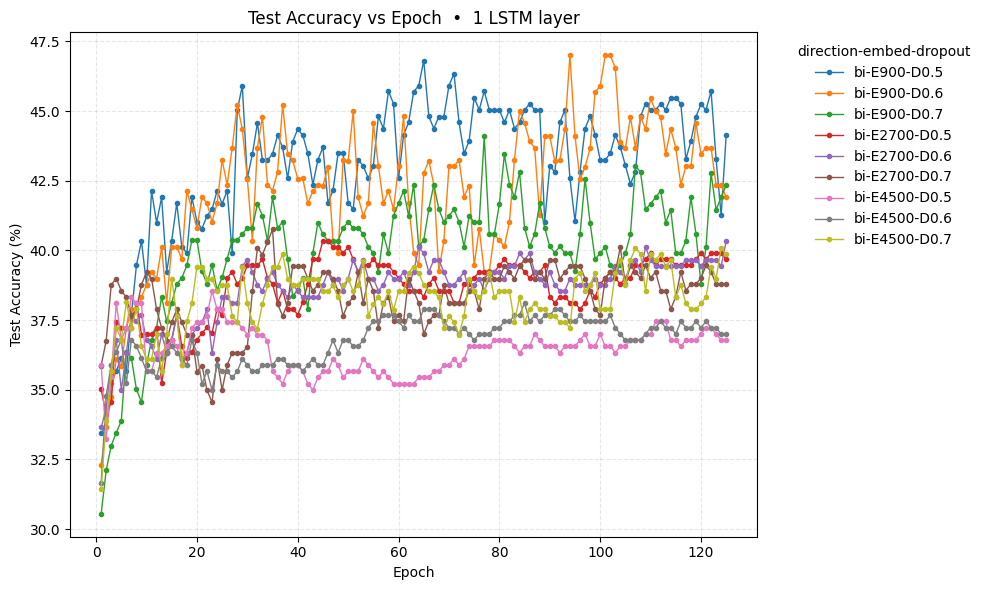

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers1.png


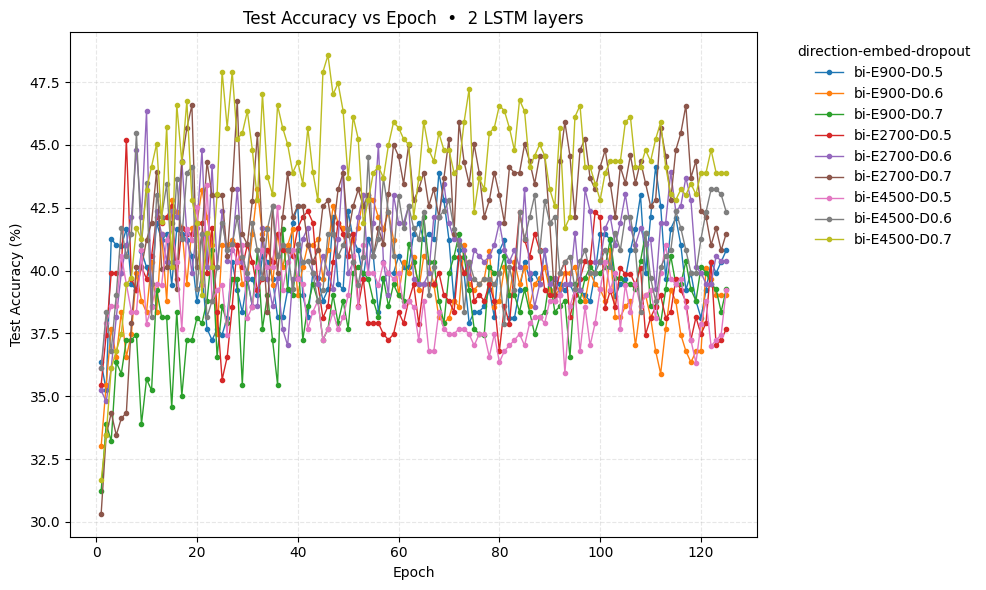

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers2.png


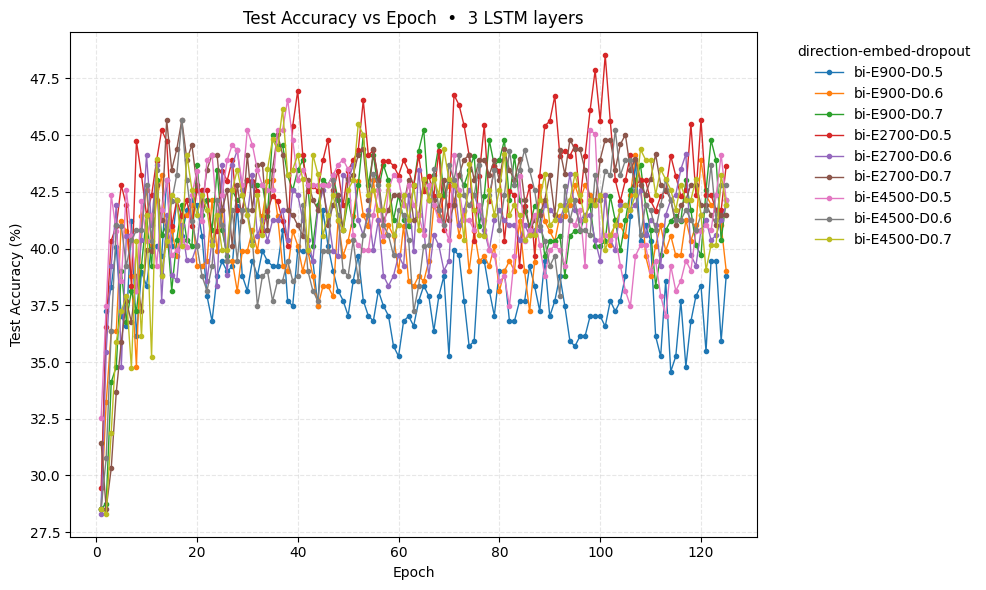

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers3.png


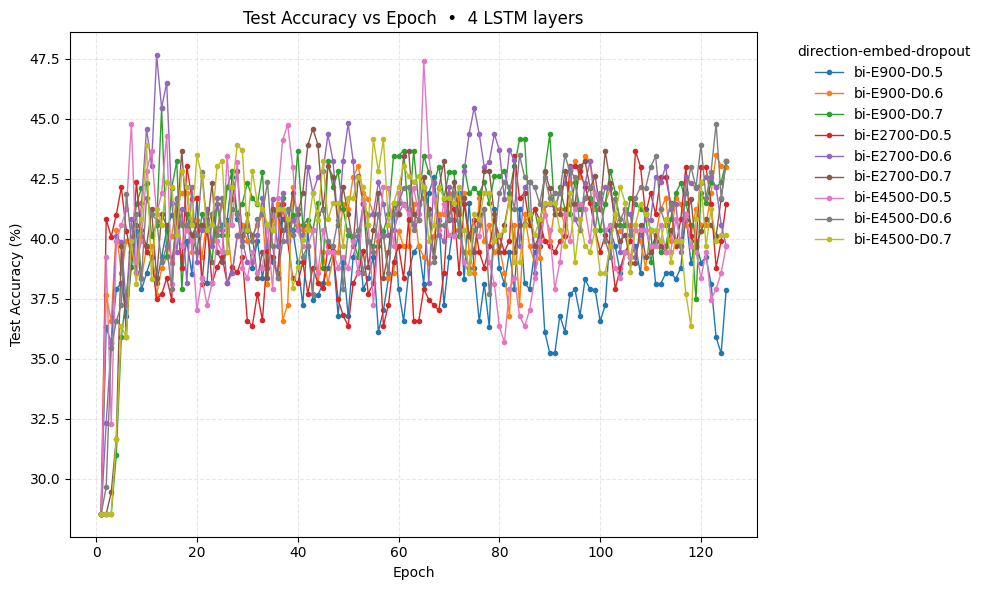

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers4.png


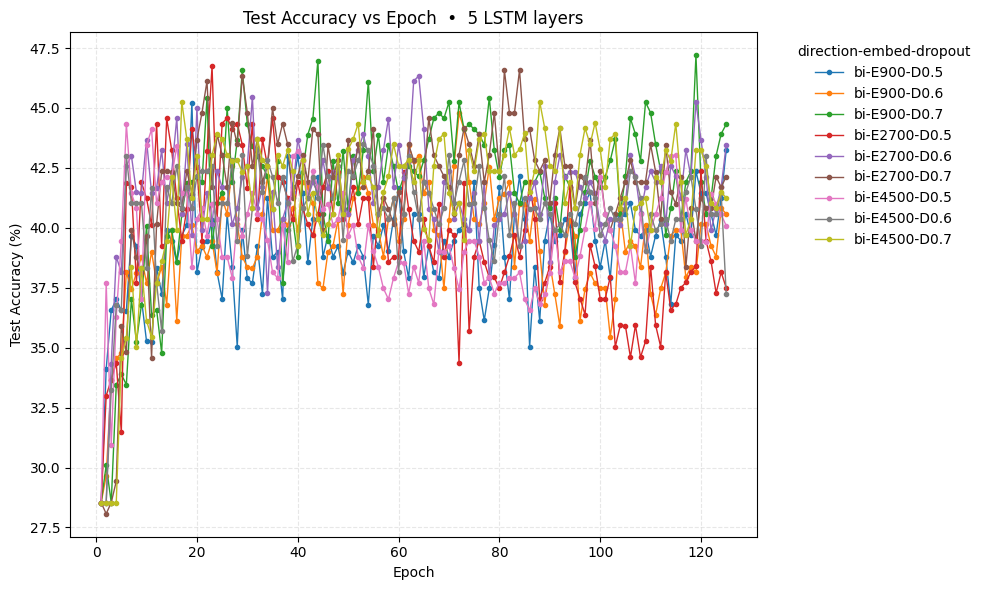

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers5.png


In [3]:
# ─────────────────────────────────────────────────────────────────────
# 0. Imports & config
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Point this to the directory that *contains* all your metrics files
root = Path("./model2/csv_metrics/metrics_old")     # <- adjust if necessary
csv_files = list(root.rglob("metrics_layers*.csv"))

# File name looks like  metrics_layers{N}_{bidir|uni}_emb{D}_drop{P}.csv
#         stem e.g. --> metrics_layers2_bidir_emb2700_drop0.6
pat = re.compile(r"metrics_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# ─────────────────────────────────────────────────────────────────────
# 1. Helper to read a single CSV and annotate it with the hyper-params
# ─────────────────────────────────────────────────────────────────────
def read_and_annotate(csv_path: Path) -> pd.DataFrame:
    # the metrics_*.csv files already contain raw numbers, so no converters are needed
    df = pd.read_csv(csv_path)

    # Parse the hyper-parameters from the FILE NAME (stem)
    m = pat.fullmatch(csv_path.stem)
    if not m:
        raise ValueError(f"File name {csv_path.name} does not match expected pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)

    return df

# ─────────────────────────────────────────────────────────────────────
# 2. Read every file and concatenate into one tidy DataFrame
# ─────────────────────────────────────────────────────────────────────
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# Optional: multi-index for easier inspection
df_all = df_all.set_index(
    ["layers", "bidir", "emb_dim", "dropout", "Epoch"]
).sort_index()

print("Preview")
print(df_all.head())

# Bring the columns back for plotting
df_filtered = df_all.reset_index()

# ─────────────────────────────────────────────────────────────────────
# 3. Five separate plots: one per 'layers' value
# ─────────────────────────────────────────────────────────────────────
layer_values = sorted(df_filtered["layers"].unique())    # e.g. [1, 2, 3, 4, 5]

out_dir = Path("./plots_by_layer")
out_dir.mkdir(exist_ok=True)

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,    # already a fraction, convert to %
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} LSTM layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False,
    )
    plt.tight_layout()

    fig_path = out_dir / f"test_acc_vs_epoch_layers{layers}.png"
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

### new_data result

Preview
                                    TrainLoss  TrainAcc  TestLoss  TestAcc
layers bidir emb_dim dropout Epoch                                        
1      True  900     0.5     1         1.1087    0.5260    0.8557   0.6708
                             2         0.8257    0.6695    0.6050   0.8019
                             3         0.6443    0.7487    0.4518   0.8755
                             4         0.5273    0.7990    0.3843   0.8887
                             5         0.4543    0.8278    0.3128   0.8954


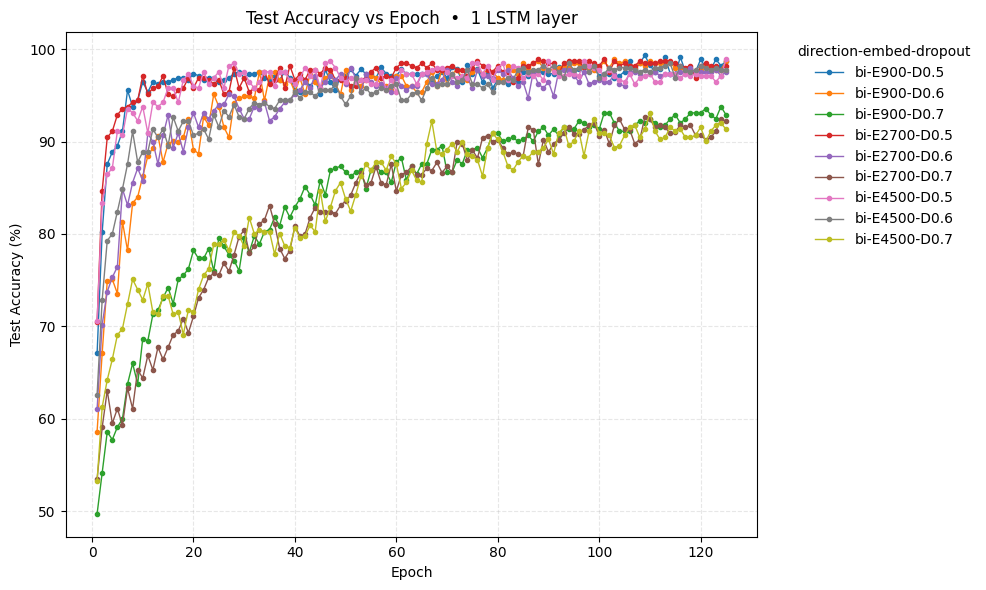

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers1.png


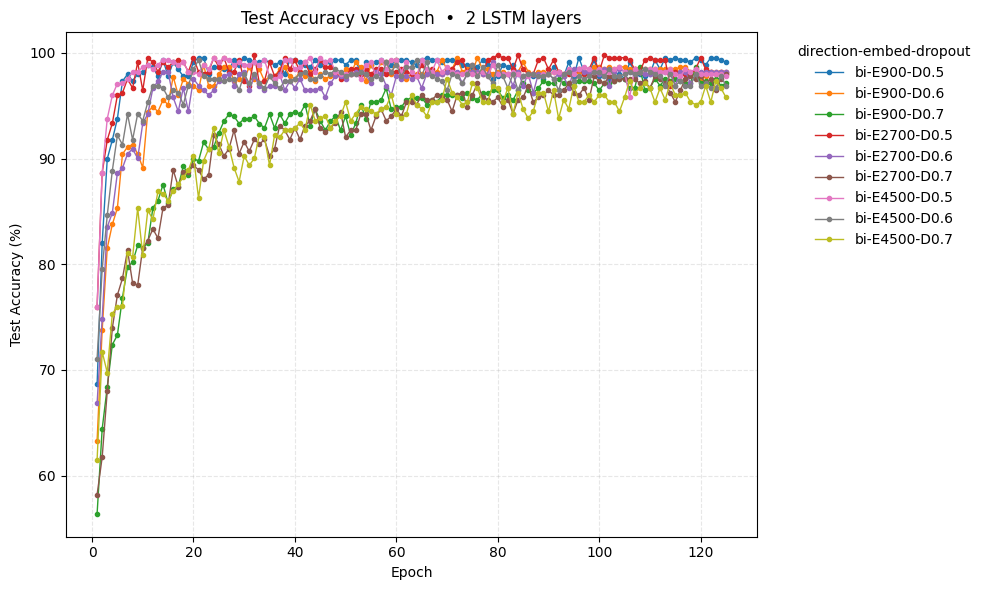

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers2.png


In [3]:
# ─────────────────────────────────────────────────────────────────────
# 0. Imports & config
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Point this to the directory that *contains* all your metrics files
root = Path("./model2/csv_metrics/metrics_new")     # <- adjust if necessary
csv_files = list(root.rglob("metrics_layers*.csv"))

# File name looks like  metrics_layers{N}_{bidir|uni}_emb{D}_drop{P}.csv
#         stem e.g. --> metrics_layers2_bidir_emb2700_drop0.6
pat = re.compile(r"metrics_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# ─────────────────────────────────────────────────────────────────────
# 1. Helper to read a single CSV and annotate it with the hyper-params
# ─────────────────────────────────────────────────────────────────────
def read_and_annotate(csv_path: Path) -> pd.DataFrame:
    # the metrics_*.csv files already contain raw numbers, so no converters are needed
    df = pd.read_csv(csv_path)

    # Parse the hyper-parameters from the FILE NAME (stem)
    m = pat.fullmatch(csv_path.stem)
    if not m:
        raise ValueError(f"File name {csv_path.name} does not match expected pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)

    return df

# ─────────────────────────────────────────────────────────────────────
# 2. Read every file and concatenate into one tidy DataFrame
# ─────────────────────────────────────────────────────────────────────
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# Optional: multi-index for easier inspection
df_all = df_all.set_index(
    ["layers", "bidir", "emb_dim", "dropout", "Epoch"]
).sort_index()

print("Preview")
print(df_all.head())

# Bring the columns back for plotting
df_filtered = df_all.reset_index()

# ─────────────────────────────────────────────────────────────────────
# 3. Five separate plots: one per 'layers' value
# ─────────────────────────────────────────────────────────────────────
layer_values = sorted(df_filtered["layers"].unique())    # e.g. [1, 2, 3, 4, 5]

out_dir = Path("./plots_by_layer")
out_dir.mkdir(exist_ok=True)

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,    # already a fraction, convert to %
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} LSTM layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False,
    )
    plt.tight_layout()

    fig_path = out_dir / f"test_acc_vs_epoch_layers{layers}.png"
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

### data_training package usage
 

In [ ]:
from model2.lstm_package import train_lstm
from pathlib import Path

run_dir = Path("model2/saved_models")
run_dir.mkdir(parents=True, exist_ok=True)
run_dir  = "model2/saved_models"

data_dir = Path("model2/data")
data_dir.mkdir(parents=True, exist_ok=True)
data_dir = "model2/data"                 # data/train / data/test

# train
res = train_lstm(data_dir, run_dir, n_epochs=3, batch_size=32)
print(res)

### data_testing package usage

In [ ]:
from model2.lstm_package import predict_texts  # import the whole module

texts = [
    'so add a fucking rick roll emte with the', 
'i rather the guy learn whatever game he enjoy the fastest. which be stupid lol',
'lucky colat i ve even get in',
'gta online update for june / july timeframe will cop and robber book it',
]

predictions = predict_texts(texts)  

# Example output (each corresponding to the input list order): [3, 0, 2, 3]
print(predictions)  

from pathlib import Path
import pandas as pd                               

csv_path = Path("Twitter_data/test.csv")
df = pd.read_csv(csv_path)
testing_dataset = df["Phrase"].astype(str).tolist()   # <- now a plain list[str]
# print(testing_dataset)

# predictions : list of model outputs 
predictions = predict_texts(testing_dataset)
print(predictions)        # raw probabilities (0-1)

# true_labels : list of gold labels
true_labels = df["Sentiment"].tolist()
print(true_labels)

# convert to hard labels and evaluate
matches = 0                       
total   = len(true_labels)      

for pred, truth in zip(predictions, true_labels):
    if pred == truth:           
        matches += 1

wrong = total - matches
accuracy_pct = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_pct:.3g}%")         
print(f"Number wrong: {wrong} out of {total}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def evaluate_classifier(
    y_true,
    y_pred,
    labels=None,
    plot_heatmap=False,
    heatmap_title="Confusion matrix"
):
    """
    Compute confusion-matrix + F1 scores (+ optional heat-map).

    Parameters
    ----------
    y_true : list | np.ndarray
        Gold labels (scalar values 0 … n_classes-1).
    y_pred : list | np.ndarray
        • Either same shape as y_true (already hard labels)  
        • Or a 2-D array/ list of per-class probabilities/logits
          (shape = [n_samples, n_classes]).
    labels : list, optional
        Order of class ids to appear in the outputs.  
        Default = sorted union of y_true and y_pred.
    plot_heatmap : bool, default False
        If True, draw a seaborn heat-map.
    heatmap_title : str
        Figure title when `plot_heatmap=True`.

    Returns
    -------
    metrics : dict
        {
          'confusion_df' : pd.DataFrame,
          'f1_macro'     : float,
          'f1_micro'     : float,
          'f1_weighted'  : float,
          'classification_report' : str
        }
    """

    # 1) Transparent handling of *probability* vs *label* predictions --------
    y_pred = np.asarray(y_pred)
    if y_pred.ndim == 2:                # probabilities → labels
        y_pred = y_pred.argmax(axis=1)

    y_true = np.asarray(y_true)

    # 2) Determine label order ------------------------------------------------
    if labels is None:
        labels = sorted(set(y_true) | set(y_pred))

    # 3) Confusion matrix -----------------------------------------------------
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(
        cm,
        index=[f"real {l}" for l in labels],
        columns=[f"pred {l}" for l in labels],
    )

    # 4) F1 scores ------------------------------------------------------------
    f1_macro    = f1_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)
    f1_micro    = f1_score(y_true, y_pred, labels=labels, average="micro", zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)

    # 5) Optional heat-map ----------------------------------------------------
    if plot_heatmap:
        import seaborn as sns, matplotlib.pyplot as plt
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.title(heatmap_title)
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.show()

    # 6) Detailed per-class report -------------------------------------------
    cls_rep = classification_report(y_true, y_pred, labels=labels, zero_division=0)

    metrics = {
        "confusion_df": cm_df,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted,
        "classification_report": cls_rep,
    }
    return metrics

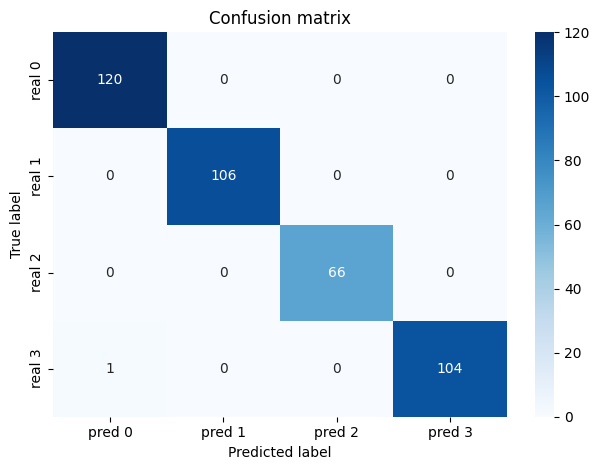

Confusion matrix:
         pred 0  pred 1  pred 2  pred 3
real 0     120       0       0       0
real 1       0     106       0       0
real 2       0       0      66       0
real 3       1       0       0     104 

F1-macro    : 0.9978
F1-micro    : 0.9975
F1-weighted : 0.9975

Full report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       120
           1       1.00      1.00      1.00       106
           2       1.00      1.00      1.00        66
           3       1.00      0.99      1.00       105

    accuracy                           1.00       397
   macro avg       1.00      1.00      1.00       397
weighted avg       1.00      1.00      1.00       397



In [ ]:
# Assuming `true_labels` and `predictions` already exist
results = evaluate_classifier(true_labels, predictions, plot_heatmap=True)

print("Confusion matrix:\n", results["confusion_df"], "\n")
print(f"F1-macro    : {results['f1_macro']:.4f}")
print(f"F1-micro    : {results['f1_micro']:.4f}")
print(f"F1-weighted : {results['f1_weighted']:.4f}\n")
print("Full report\n", results["classification_report"])

## Section 3 Model3: 

In [ ]:
# Implement here
...

## Section 3 Model4:

In [ ]:
# Implement here
...

## Section 3 Model5: 
#### Models: TF-IDF and Naive Bayes 

#### This part introduces the approach of using Naive Bayes as the data analytical model and TF-IDF as the text-embedding model for Twitter sentiment analysis. Here are the testing done for these two models.
#### 1. For Naive Bayes, the function `MultinomialNB()` only has a tunable parameter `alpha` based on the dataset provided, which is 1 by default. Moreover, multinominal Naive Bayes is used as we have a multi-class (>2) dataset.
#### 2. For TF-IDF, I first set the parameters in `TfidfVectorizer()` to be `min_df=2, max_df=0.95, ngram_range=(1,1)`, the result is not satisfactory. 
#### 3. Next, in TF-IDF, I set the parameters in `TfidfVectorizer()` to be `min_df=4, max_df=0.95, ngram_range=(1,2)`, the result has improved a bit (test accuracy) but still far from perfect. 
#### 4. Finally, I used a further fine-tuned training dataset, trained by a pre-trained model, to train a TF-IDF and Naive Bayes models, which obtain a significantly better result.

In [1]:
# Implement here
# Initialize the model and explain about the development of each model one by one. (Here you also discuss the "step 2" of instruction 3)

from model5.package.model import load_saved_model, evaluate_saved_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pretrain_csv_path = 'Twitter_data/pre_traindata7.csv'
train_csv_path = 'Twitter_data/traindata7.csv'
test_csv_path = 'Twitter_data/testdata7.csv'

sample_texts = ["I love this!", "I hate this!", "Sounds alright."]

### Test with standard model trained with standard dataset.

In [2]:
'''
1. Test with standard model trained with standard dataset.
(Parameters for TF-IDF: min_df=2, max_df=0.95, ngram_range=(1,1))
'''
# Initialize the models
model5_standard = load_saved_model('model5/saved_models_standard')

model5_standard_tfidf_model: TfidfVectorizer = model5_standard['embedding']
model5_standard_nb_model: MultinomialNB = model5_standard['model']

# Evaluate the model on training and testing datasets
model5_standard_eval_result = evaluate_saved_model(model5_standard, train_csv_path, test_csv_path)
model5_standard_train_loss      = model5_standard_eval_result.get('train').get('loss')
model5_standard_train_accuracy  = model5_standard_eval_result.get('train').get('accuracy')
model5_standard_test_loss       = model5_standard_eval_result.get('test').get('loss')
model5_standard_test_accuracy   = model5_standard_eval_result.get('test').get('accuracy')
print("\nEvaluation Results for Standard Model:")
print(f"Train loss: {model5_standard_train_loss}, Train accuracy: {model5_standard_train_accuracy}")
print(f"Test loss: {model5_standard_test_loss}, Test accuracy: {model5_standard_test_accuracy}")

# Prediction Result
embedded_texts = model5_standard_tfidf_model.transform(sample_texts)
nb_predictions = model5_standard_nb_model.predict(embedded_texts)
print("\nSample Predictions:")
for t, p in zip(sample_texts, nb_predictions):
    print(f"Text: '{t}' => Predicted Sentiment: {p}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/21 14:35:16 WARN Utils: Your hostname, Marcuss-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.11.101.207 instead (on interface en0)
25/11/21 14:35:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/21 14:35:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Evaluation Results for Standard Model:
Train loss: 0.9161253411038153, Train accuracy: 78.35570469798657
Test loss: 1.2396074540171473, Test accuracy: 47.607052896725435

Sample Predictions:
Text: 'I love this!' => Predicted Sentiment: 1
Text: 'I hate this!' => Predicted Sentiment: 1
Text: 'Sounds alright.' => Predicted Sentiment: 0


### Test with tuned model trained with standard dataset.

In [3]:
'''
2. Test with tuned model trained with standard dataset.
(Parameters for TF-IDF: min_df=4, max_df=0.95, ngram_range=(1,2))
'''
# Initialize the models
model5_tuned = load_saved_model('model5/saved_models_tuned')

model5_tuned_tfidf_model: TfidfVectorizer = model5_tuned['embedding']
model5_tuned_nb_model: MultinomialNB = model5_tuned['model']

# Evaluate the model on training and testing datasets
model5_tuned_eval_result = evaluate_saved_model(model5_tuned, train_csv_path, test_csv_path)

model5_tuned_train_loss      = model5_tuned_eval_result.get('train').get('loss')
model5_tuned_train_accuracy  = model5_tuned_eval_result.get('train').get('accuracy')
model5_tuned_test_loss       = model5_tuned_eval_result.get('test').get('loss')
model5_tuned_test_accuracy   = model5_tuned_eval_result.get('test').get('accuracy')

print("\nEvaluation Results for Tuned Model:")
print(f"Train loss: {model5_tuned_train_loss}, Train accuracy: {model5_tuned_train_accuracy}")
print(f"Test loss: {model5_tuned_test_loss}, Test accuracy: {model5_tuned_test_accuracy}")

# Prediction Result
embedded_texts = model5_tuned_tfidf_model.transform(sample_texts)
nb_predictions = model5_tuned_nb_model.predict(embedded_texts)

print("\nSample Predictions:")
for t, p in zip(sample_texts, nb_predictions):
    print(f"Text: '{t}' => Predicted Sentiment: {p}")


Evaluation Results for Tuned Model:
Train loss: 0.9433591455740173, Train accuracy: 75.50335570469798
Test loss: 1.221114437210957, Test accuracy: 50.62972292191436

Sample Predictions:
Text: 'I love this!' => Predicted Sentiment: 1
Text: 'I hate this!' => Predicted Sentiment: 1
Text: 'Sounds alright.' => Predicted Sentiment: 0


#### Test with tuned model trained with *pre-trained* dataset.

In [6]:
'''
3. Test with tuned model trained with *pre-trained* dataset.
(Parameters for TF-IDF: min_df=4, max_df=0.95, ngram_range=(1,2))
'''
# Initialize the models
model5_pretrain = load_saved_model('model5/saved_models_pretrain7')

model5_pretrain_tfidf_model: TfidfVectorizer = model5_pretrain['embedding']
model5_pretrain_nb_model: MultinomialNB = model5_pretrain['model']

# Evaluate the model on training and testing datasets
model5_pretrain_eval_result = evaluate_saved_model(model5_pretrain, pretrain_csv_path, test_csv_path)

model5_pretrain_train_loss      = model5_pretrain_eval_result.get('train').get('loss')
model5_pretrain_train_accuracy  = model5_pretrain_eval_result.get('train').get('accuracy')
model5_pretrain_test_loss       = model5_pretrain_eval_result.get('test').get('loss')
model5_pretrain_test_accuracy   = model5_pretrain_eval_result.get('test').get('accuracy')

print("\nEvaluation Results for Pretrained Model:")
print(f"Train loss: {model5_pretrain_train_loss}, Train accuracy: {model5_pretrain_train_accuracy}")
print(f"Test loss: {model5_pretrain_test_loss}, Test accuracy: {model5_pretrain_test_accuracy}")

# Prediction Result
embedded_texts = model5_pretrain_tfidf_model.transform(sample_texts)
nb_predictions = model5_pretrain_nb_model.predict(embedded_texts)

print("\nSample Predictions:")
for t, p in zip(sample_texts, nb_predictions):
    print(f"Text: '{t}' => Predicted Sentiment: {p}")


Evaluation Results for Pretrained Model:
Train loss: 0.5177415981622627, Train accuracy: 85.63328636664573
Test loss: 0.5199800017170164, Test accuracy: 84.38287153652394

Sample Predictions:
Text: 'I love this!' => Predicted Sentiment: 1
Text: 'I hate this!' => Predicted Sentiment: 0
Text: 'Sounds alright.' => Predicted Sentiment: 3


### Prelimary analysis with graph
The line graph of the training accuracies and testing accuracies for each tested model.

In [11]:
import matplotlib.pyplot as plt

# Prepare data for plotting
models = ['Standard', 'Fine-Tuned', 'Pretrained Training Data']
train_accuracies = [
    model5_standard_train_accuracy,
    model5_tuned_train_accuracy,
    model5_pretrain_train_accuracy
]
test_accuracies = [
    model5_standard_test_accuracy,
    model5_tuned_test_accuracy,
    model5_pretrain_test_accuracy
]
train_losses = [
    model5_standard_train_loss,
    model5_tuned_train_loss,
    model5_pretrain_train_loss
]  
test_losses = [
    model5_standard_test_loss,
    model5_tuned_test_loss,
    model5_pretrain_test_loss
]
x = range(len(models))

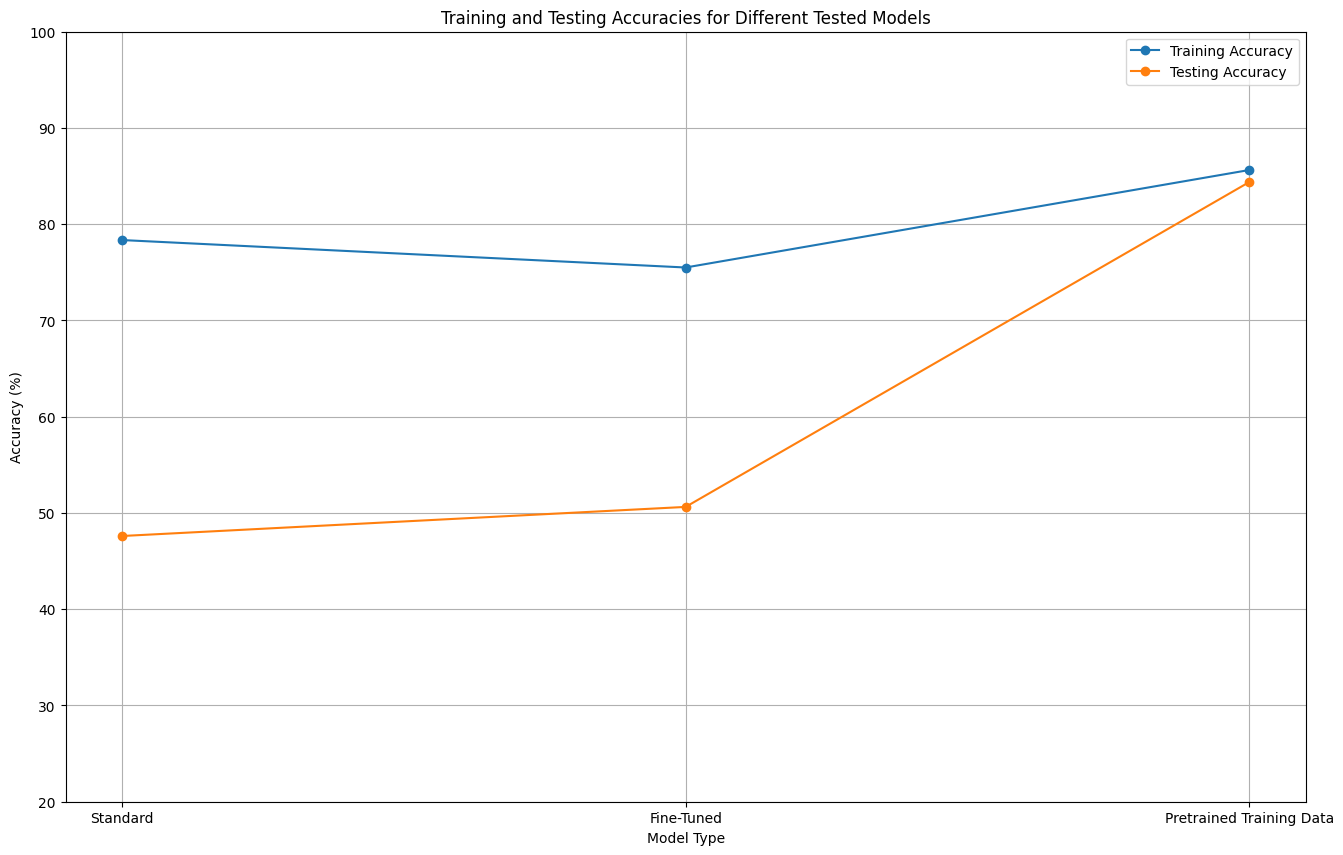

In [16]:
# Plotting
plt.figure(figsize=(16, 10))
plt.plot(x, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(x, test_accuracies, marker='o', label='Testing Accuracy')
plt.xticks(x, models)
plt.ylim(20, 100)
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies for Different Tested Models')
plt.legend()
plt.grid(True)
plt.show()

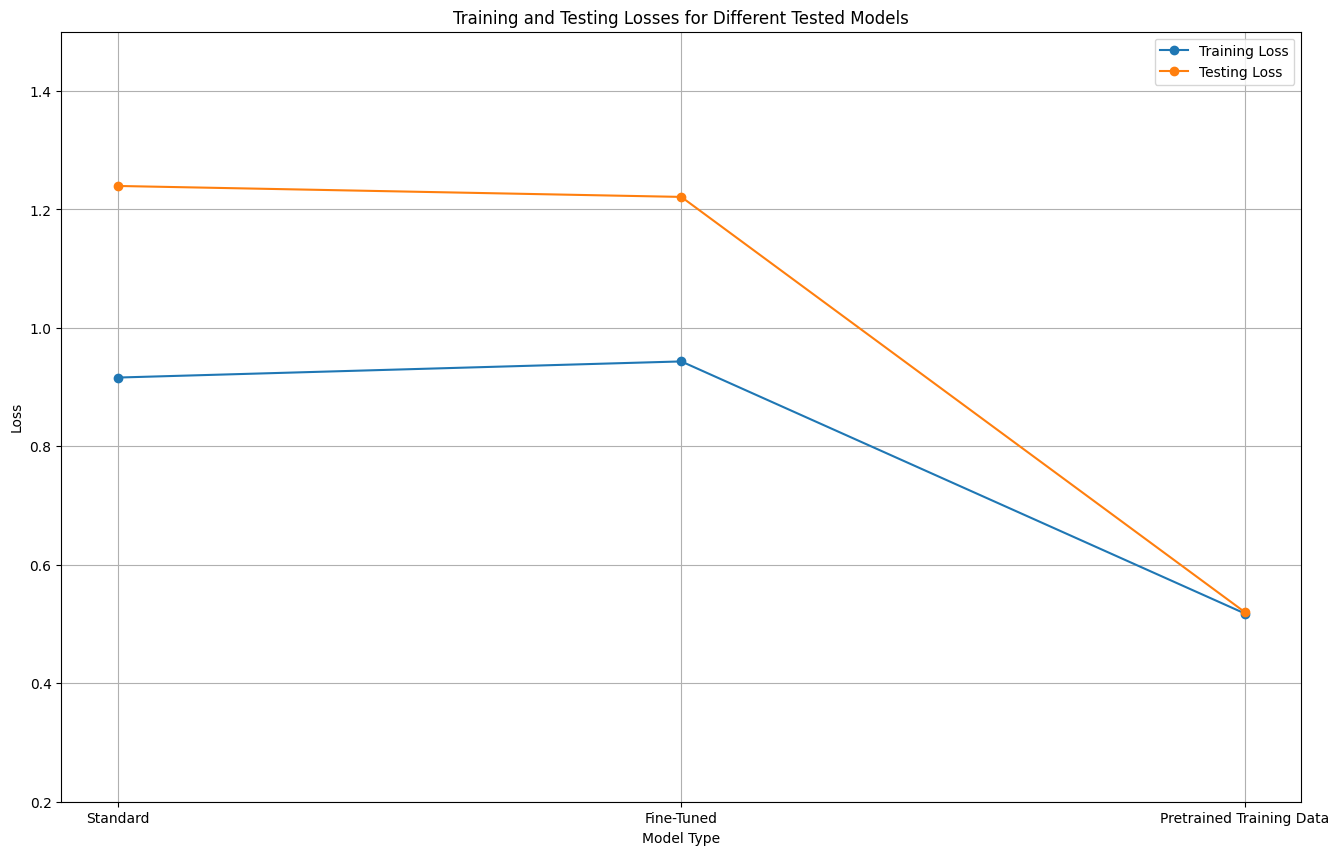

In [17]:
# Plotting
plt.figure(figsize=(16, 10))
plt.plot(x, train_losses, marker='o', label='Training Loss')
plt.plot(x, test_losses, marker='o', label='Testing Loss')
plt.xticks(x, models)
plt.ylim(0.2, 1.5)
plt.xlabel('Model Type')
plt.ylabel('Loss')
plt.title('Training and Testing Losses for Different Tested Models')
plt.legend()
plt.grid(True)
plt.show()

## Section 3 Model6:

In [ ]:
# Implement here
...

## Section 3 Model7:

Preview
                                    TrainLoss  TrainAcc  TestLoss  TestAcc
layers bidir emb_dim dropout Epoch                                        
1      False 900     0.5     1         1.2875    0.4271    1.1432   0.5038
                             2         1.1473    0.5245    0.9987   0.5706
                             3         1.0455    0.5816    0.9072   0.6042
                             4         0.9611    0.6212    0.8492   0.6533
                             5         0.8855    0.6551    0.7353   0.7399


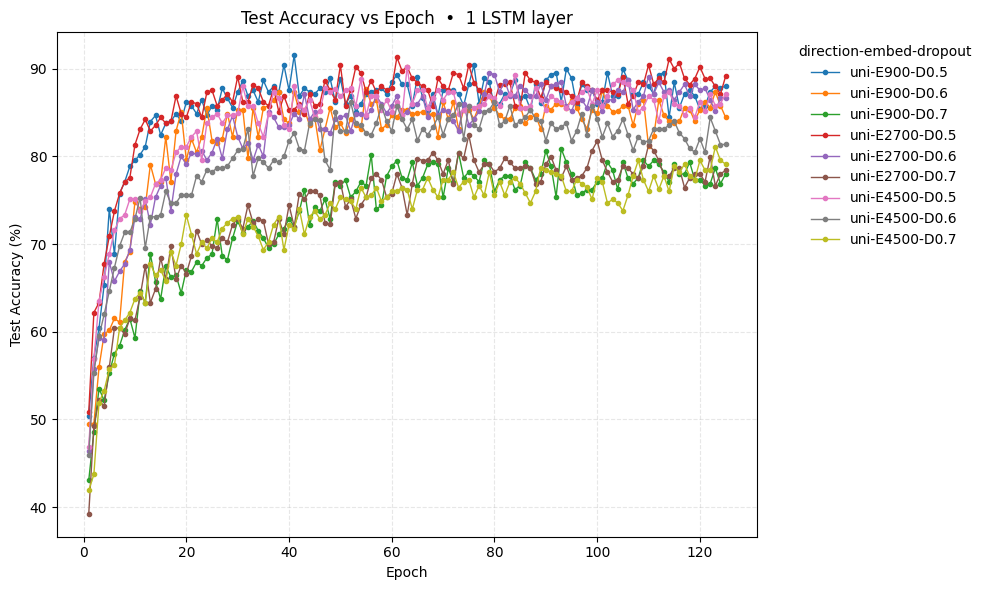

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers1.png


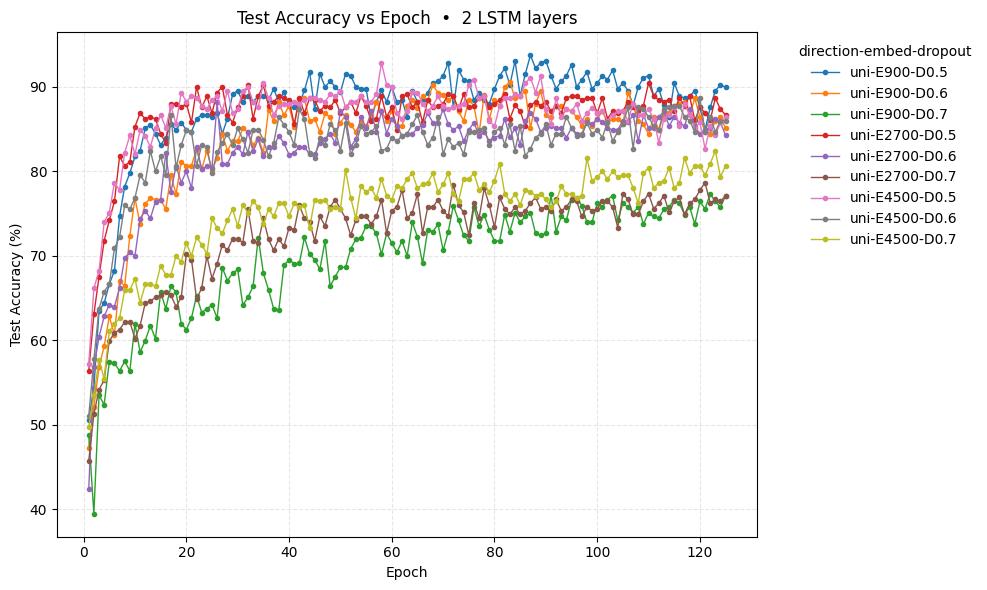

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers2.png


In [4]:
# ─────────────────────────────────────────────────────────────────────
# 0. Imports & config
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re


root = Path("./model7/metrics/")     
csv_files = list(root.rglob("metrics_layers*.csv"))


pat = re.compile(r"metrics_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# ─────────────────────────────────────────────────────────────────────
# 1. Helper to read a single CSV and annotate it with the hyper-params
# ─────────────────────────────────────────────────────────────────────
def read_and_annotate(csv_path: Path) -> pd.DataFrame:
    # the metrics_*.csv files already contain raw numbers, so no converters are needed
    df = pd.read_csv(csv_path)

    # Parse the hyper-parameters from the FILE NAME (stem)
    m = pat.fullmatch(csv_path.stem)
    if not m:
        raise ValueError(f"File name {csv_path.name} does not match expected pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)

    return df

# ─────────────────────────────────────────────────────────────────────
# 2. Read every file and concatenate into one tidy DataFrame
# ─────────────────────────────────────────────────────────────────────
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# Optional: multi-index for easier inspection
df_all = df_all.set_index(
    ["layers", "bidir", "emb_dim", "dropout", "Epoch"]
).sort_index()

print("Preview")
print(df_all.head())

# Bring the columns back for plotting
df_filtered = df_all.reset_index()

# ─────────────────────────────────────────────────────────────────────
# 3. Five separate plots: one per 'layers' value
# ─────────────────────────────────────────────────────────────────────
layer_values = sorted(df_filtered["layers"].unique())    # e.g. [1, 2, 3, 4, 5]

out_dir = Path("./plots_by_layer")
out_dir.mkdir(exist_ok=True)

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,    # already a fraction, convert to %
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} LSTM layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False,
    )
    plt.tight_layout()

    fig_path = out_dir / f"test_acc_vs_epoch_layers{layers}.png"
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

# Section 4: Comparison

In [ ]:
# Implement here
...